In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sqlite3
import requests
import pandas as pd
import numpy as np
import time
from datetime import datetime
import concurrent.futures
import matplotlib.pyplot as plt

In [ ]:
DATABASE_FILE_PATH = '/content/drive/MyDrive/crypto_data.db'
COINS_TO_FETCH = ['BTC-USDT', 'ETH-USDT', 'SOL-USDT', 'ADA-USDT', 'XRP-USDT', 'DOGE-USDT']
REAL_COINS_SYMBOLS = [coin.replace('-USDT', 'USDT') for coin in COINS_TO_FETCH]

####PART 1: DATA PIPELINE

In [ ]:
def fetch_and_update_database():
    """Fetches and stores raw historical data for all coins."""
    print("--- PART 1: FETCHING AND UPDATING RAW DATA ---")
    all_data_for_db = []
    def _fetch_single_coin_data(symbol):
        url = f"https://api.kucoin.com/api/v1/market/candles?type=1day&symbol={symbol}&startAt={int(time.time()) - (4000 * 24 * 60 * 60)}"
        print(f"Fetching data for {symbol}...")
        try:
            response = requests.get(url)
            response.raise_for_status()
            raw_data = response.json()['data']
            processed_data = []
            for row in raw_data:
                processed_data.append((
                    int(row[0]) * 1000,
                    datetime.fromtimestamp(int(row[0])).strftime('%Y-%m-%d'),
                    symbol.replace('-', ''),
                    float(row[1]), float(row[3]), float(row[4]), float(row[2]),
                    float(row[5]), float(row[6])
                ))
            return processed_data
        except requests.exceptions.RequestException: return []
    with concurrent.futures.ThreadPoolExecutor(max_workers=len(COINS_TO_FETCH)) as executor:
        for result in executor.map(_fetch_single_coin_data, COINS_TO_FETCH):
            all_data_for_db.extend(result)
    conn = sqlite3.connect(DATABASE_FILE_PATH)
    cur = conn.cursor()
    cur.execute("CREATE TABLE IF NOT EXISTS crypto_prices (id INTEGER PRIMARY KEY, Unix INTEGER, Date TEXT, Symbol TEXT, Open REAL, High REAL, Low REAL, Close REAL, Volume_Base REAL, Volume_Quote REAL, UNIQUE(Symbol, Unix))")
    cur.executemany("INSERT OR IGNORE INTO crypto_prices (Unix, Date, Symbol, Open, High, Low, Close, Volume_Base, Volume_Quote) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)", all_data_for_db)
    conn.commit()
    print(f"\nDatabase is ready. Inserted {cur.rowcount} new records into 'crypto_prices'.")
    conn.close()

#### PART 2: DYNAMIC PORTFOLIO BACKTESTING ENGINE

In [ ]:
def dynamic_strategy_backtest(strategy_name, daily_returns_df, lookback_window, rebalance_frequency):

    print(f"[THREAD] Starting backtest for: {strategy_name}...")

    portfolio_returns = pd.Series(index=daily_returns_df.index, dtype=float)
    current_weights = {}

    for i in range(lookback_window, len(daily_returns_df)):
        # Check if it's time to rebalance the portfolio
        if (i - lookback_window) % rebalance_frequency == 0:
            # --- This is the core of the DYNAMIC allocation ---
            # 1. Get the recent history for calculation
            historical_slice = daily_returns_df.iloc[i - lookback_window : i]

            # 2. Calculate weights based on the strategy
            if "Risk-Parity" in strategy_name:
                volatilities = historical_slice.std()
                inverse_volatilities = 1 / (volatilities + 1e-6)
                current_weights = (inverse_volatilities / inverse_volatilities.sum()).to_dict()
            elif "Equal-Weight" in strategy_name:
                num_assets = len(daily_returns_df.columns)
                current_weights = {asset: 1/num_assets for asset in daily_returns_df.columns}

        # 3. Calculate the portfolio's return for the current day using the latest weights
        todays_returns = daily_returns_df.iloc[i]
        portfolio_return_today = 0
        for asset, weight in current_weights.items():
            if not np.isnan(todays_returns[asset]):
                portfolio_return_today += todays_returns[asset] * weight

        portfolio_returns.iloc[i] = portfolio_return_today

    print(f"[THREAD] Finished backtest for: {strategy_name}.")
    return portfolio_returns.dropna()

#### PART 3: MAIN EXECUTION WITH PARALLEL BACKTESTS


--- PART 2: RUNNING DYNAMIC BACKTESTS IN PARALLEL ---
[THREAD] Starting backtest for: Risk-Parity-90d...
[THREAD] Starting backtest for: Risk-Parity-30d...
[THREAD] Starting backtest for: Equal-Weight...
'Equal-Weight' generated an exception: integer modulo by zero
[THREAD] Finished backtest for: Risk-Parity-90d.
[THREAD] Finished backtest for: Risk-Parity-30d.

FINAL CONCLUSION: Dynamic Strategy Performance vs. Risk-Adjusted Return
                 Final Value of $100  CAGR (%)  Volatility (Risk) %  \
Risk-Parity-30d               194.13     17.91                 3.50   
Risk-Parity-90d               171.12     14.92                 3.49   

                 Sharpe Ratio  
Risk-Parity-30d        0.5803  
Risk-Parity-90d        0.5422  

Generating final comparison plot...


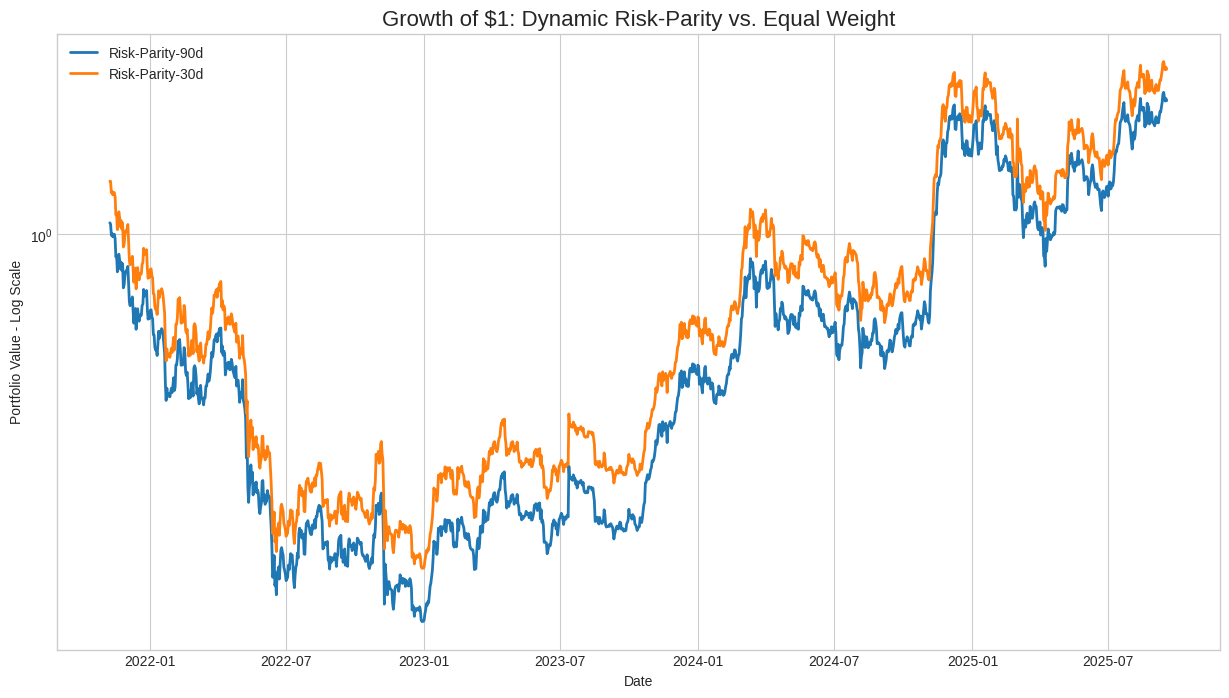


--- FULL PIPELINE COMPLETE ---


In [ ]:
if __name__ == "__main__":
    # In a real run, you would uncomment this to get fresh data.
    # For this example, we assume the DB is already populated.
    # fetch_and_update_database()

    print("\n--- PART 2: RUNNING DYNAMIC BACKTESTS IN PARALLEL ---")
    conn = sqlite3.connect(DATABASE_FILE_PATH)
    try:
        query = "SELECT Date, Symbol, Close FROM crypto_prices ORDER BY Date ASC"
        df = pd.read_sql_query(query, conn, parse_dates=['Date'])
    except Exception as e:
        print(f"FATAL ERROR: Could not read database. Please run the data pipeline first. Error: {e}")
        exit()
    finally:
        conn.close()

    prices_df = df.pivot(index='Date', columns='Symbol', values='Close')
    daily_returns_df = prices_df[REAL_COINS_SYMBOLS].pct_change() # Use fractional returns

    # --- Define the strategies to test in parallel ---
    # Format: 'Strategy Name': (lookback_window, rebalance_frequency)
    strategies_to_test = {
        'Risk-Parity-90d': (90, 30), # Use 90 days of history, rebalance every 30 days
        'Risk-Parity-30d': (30, 30), # Use 30 days of history, rebalance every 30 days
        'Equal-Weight': (0, 0)       # Special case for the simple benchmark
    }

    backtest_results = {}

    # --- Use a ThreadPool to run all backtests at the same time ---
    with concurrent.futures.ThreadPoolExecutor(max_workers=len(strategies_to_test)) as executor:
        future_to_strategy = {
            executor.submit(dynamic_strategy_backtest, name, daily_returns_df, params[0], params[1]): name
            for name, params in strategies_to_test.items()
        }
        for future in concurrent.futures.as_completed(future_to_strategy):
            strategy_name = future_to_strategy[future]
            try:
                result = future.result()
                backtest_results[strategy_name] = result
            except Exception as exc:
                print(f"'{strategy_name}' generated an exception: {exc}")

    # --- PART 3: Analyze and Display the Results ---
    print("\n" + "="*80)
    print("FINAL CONCLUSION: Dynamic Strategy Performance vs. Risk-Adjusted Return")
    print("="*80)

    # Calculate final metrics for each strategy
    summary = {}
    for name, returns in backtest_results.items():
        returns_pct = returns * 100
        cumulative_growth = (1 + returns).cumprod()
        final_value = cumulative_growth.iloc[-1] * 100
        cagr = ((final_value / 100) ** (365 / len(returns)) - 1) * 100
        volatility = returns_pct.std()
        sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(365) if volatility != 0 else 0
        summary[name] = {
            'Final Value of $100': round(final_value, 2),
            'CAGR (%)': round(cagr, 2),
            'Volatility (Risk) %': round(volatility, 2),
            'Sharpe Ratio': round(sharpe_ratio, 4)
        }

    summary_df = pd.DataFrame.from_dict(summary, orient='index').sort_values(by='Sharpe Ratio', ascending=False)
    print(summary_df)

    # --- Plot the final results ---
    print("\nGenerating final comparison plot...")
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(15, 8))

    # Create cumulative growth DataFrame for plotting
    plot_df = pd.DataFrame()
    for name, returns in backtest_results.items():
        plot_df[name] = (1 + returns).cumprod()

    for col in plot_df.columns:
        plt.plot(plot_df.index, plot_df[col], label=col, linewidth=2)

    plt.title('Growth of $1: Dynamic Risk-Parity vs. Equal Weight', fontsize=16)
    plt.ylabel('Portfolio Value - Log Scale')
    plt.xlabel('Date')
    plt.legend(loc='upper left')
    plt.yscale('log')
    plt.show()

    print("\n--- FULL PIPELINE COMPLETE ---")